# Notebook to create train & test set of images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv


path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Load each dataset of tiles:

In [3]:
## Save list to file:
# lca.save_tile_names_to_list(list_tile_names=list(df_tiles_eval['PLAN_NO'].unique()), text_filename='content/evaluation_sample_50tiles/evaluation_sample_50tiles_list.txt')
 
no_class_threshold = 1.0
 ## LC polygons:
df_lc_80s, mapping_class_inds = lca.load_landcover(pol_path=path_dict['lc_80s_path'])
df_lc_80s = lca.add_main_category_column(df_lc=df_lc_80s)
df_lc_2022 = lca.load_pols(pol_path=path_dict['evaluation_50tiles_polygons'])


## Get list of tile names from text file:
list_ds_names = ['unchanged', 'forest', 'eval', 'all', 'cde_training']
dict_ds_tile_names_file = {'unchanged': '/home/tplas/repos/cnn-land-cover/content/tiles_few_changes/tiles_few_changes_list.txt',
                           'cde_training': '/home/tplas/repos/cnn-land-cover/content/CDE_training_tiles/CDE_training_tiles.shp',
                           'forest': '/home/tplas/repos/cnn-land-cover/content/forest_tiles/forest_tiles_list.txt', 
                           'eval': '/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles_list.txt'}
dict_ds_expected_n_tiles = {'forest': 5, 'eval': 50, 'unchanged': 40}
dict_ds_tile_names = {}
dict_df_tiles = {}
dict_dict_intersect_pols = {}
dict_df_class_distr = {}
for name_ds in list_ds_names:
    print(f'\nNow loading {name_ds} tiles.')

    if name_ds != 'all':
        if dict_ds_tile_names_file[name_ds][-4:] == '.txt':
            ## Load list of tile names:
            with open(dict_ds_tile_names_file[name_ds], 'r') as f:
                tmp = f.readlines()
            dict_ds_tile_names[name_ds] = [x.rstrip('\n') for x in tmp]

            ## Select tiles by name & save as new shp file
            dict_df_tiles[name_ds] = lca.select_tiles_from_list(list_tile_names=dict_ds_tile_names[name_ds], 
                                        save_new_shp=False,
                                        new_shp_filename=dict_ds_tile_names_file[name_ds].rstrip('.txt').rstrip('_list'))

        elif dict_ds_tile_names_file[name_ds][-4:] == '.shp':
            dict_df_tiles[name_ds] = lca.load_pols(dict_ds_tile_names_file[name_ds])
    elif name_ds == 'all':
        dict_df_tiles[name_ds] = lca.get_shp_all_tiles()

    if name_ds in dict_ds_expected_n_tiles.keys():
        assert len(dict_df_tiles[name_ds]) == dict_ds_expected_n_tiles[name_ds], 'Not expected number of tiles. Perhaps this is second pass?'

    dict_dict_intersect_pols[name_ds] = lca.get_pols_for_tiles(df_pols=df_lc_80s, df_tiles=dict_df_tiles[name_ds], col_name='PLAN_NO')

    assert False, 'Below code isnt up to date anyomre because of 0 Class. have resolved this in Figures data summary.ipynb, but need to update here too.'
    
    ## Calculate distribution of classes for each tile:
    dict_df_class_distr[name_ds] = lca.create_df_with_class_distr_per_tile(dict_dfs=dict_dict_intersect_pols[name_ds], 
                                                         all_class_names=list(df_lc_80s['LC_D_80'].unique()),
                                                         no_class_threshold=no_class_threshold)
    dict_df_tiles[name_ds] = dict_df_tiles[name_ds][np.isin(dict_df_tiles[name_ds]['PLAN_NO'], dict_df_class_distr[name_ds]['tile_name'])]
    assert len(dict_df_tiles[name_ds]) == len(dict_df_class_distr[name_ds])



Now loading unchanged tiles.


100%|██████████| 40/40 [00:01<00:00, 31.47it/s]
40it [00:00, 257.85it/s]



Now loading forest tiles.


100%|██████████| 5/5 [00:00<00:00, 22.86it/s]
5it [00:00, 171.60it/s]



Now loading eval tiles.


100%|██████████| 50/50 [00:01<00:00, 32.14it/s]
50it [00:00, 300.64it/s]



Now loading all tiles.


100%|██████████| 2125/2125 [01:00<00:00, 34.97it/s]
2125it [00:06, 332.26it/s]


1617/2125 tiles kept after no-class filter

Now loading cde_training tiles.


100%|██████████| 10/10 [00:00<00:00, 34.28it/s]
10it [00:00, 174.68it/s]


## Show distribution of classes of tiles

Text(0.5, 1.0, 'Distribution of LC of entire PD')

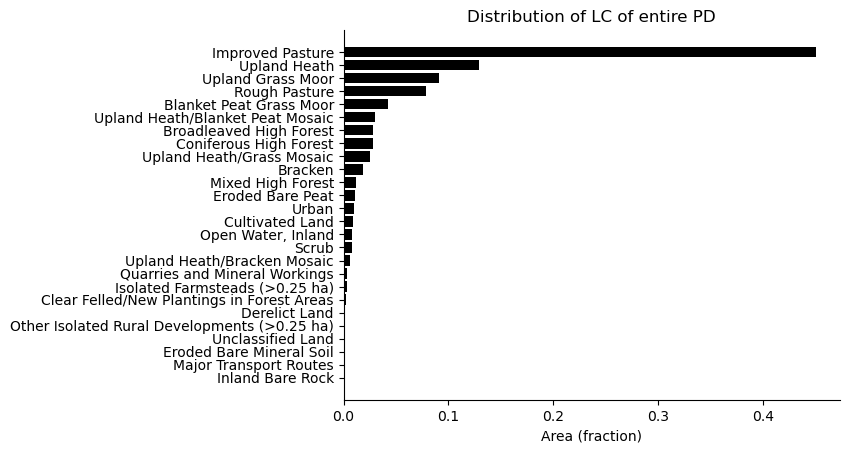

In [11]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')

In [12]:
dict_df_class_distr['all'].sort_values('Urban')
# dict_df_tiles['all'][np.isin(dict_df_tiles['all']['PLAN_NO'], ['SK2168', 'SK2572', 'SK2381'])].to_file('/home/tplas/data/gis/most recent APGB 12.5cm aerial/urban_tiles/3_urban_tiles')

,tile_name,Improved Pasture,Upland Heath/Grass Mosaic,Upland Grass Moor,Blanket Peat Grass Moor,Rough Pasture,Other Isolated Rural Developments (>0.25 ha),"Open Water, Inland",Isolated Farmsteads (>0.25 ha),Unclassified Land,...,Inland Bare Rock,Eroded Bare Mineral Soil,Quarries and Mineral Workings,Mixed High Forest,Eroded Bare Peat,Scrub,Clear Felled/New Plantings in Forest Areas,Cultivated Land,Major Transport Routes,NO CLASS
2,SE0002,0.000000,0.010399,0.055990,0.066205,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.038701,0.000000,0.000000,0.017018,0.000000,0.0,0.000000,0.000000,0.680924
1353,SK1598,0.000000,0.000000,0.009231,0.012834,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000004
1352,SK1597,0.000000,0.127743,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1351,SK1596,0.000000,0.067869,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1350,SK1595,0.000000,0.121382,0.006669,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,SK2381,0.470397,0.000000,0.000000,0.000000,0.033326,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000007,0.023839,0.000000,0.025933,0.0,0.000000,0.016973,0.000002
1693,SK2268,0.416942,0.000000,0.000000,0.000000,0.046622,0.006251,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.117412,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1657,SK2182,0.447130,0.000000,0.000000,0.000000,0.000000,0.003747,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.012456,0.0,0.000048,0.024814,0.000004
1842,SK2572,0.447332,0.000000,0.000000,0.000000,0.013807,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000026,0.000000,0.002611,0.0,0.000000,0.000000,0.000000


### Forest:
- SK2567 pretty good. 75% forest which is 80% correct maybe 
- SK2669 is great
- SK2377 great too
- SK2391, 50% coniferous or os
- SK2479 great for broadleaf 


In [79]:
list_forest_tiles = ['SK2567', 'SK2669', 'SK2377', 'SK2391', 'SK2479']
df_forest_tiles = lca.select_tiles_from_list(list_tile_names=list_forest_tiles, 
                                 save_new_shp=True,
                                 new_shp_filename='content/forest_tiles/forest_tiles')

### Forest 2:

In [4]:
list_forest_tiles = ['SK1885', 'SK2060', 'SK1690', 'SK2291', 'SJ9665', 'SK2772', 'SK2595']
df_forest_tiles = lca.select_tiles_from_list(list_tile_names=list_forest_tiles, 
                                 save_new_shp=True,
                                 new_shp_filename='../content/forest_tiles/forest_tiles_2')

## Get sample:

In [24]:
# df_class_distr_unchanged
# df_class_distr_joint = pd.concat([df_class_distr_unchanged, df_class_distr_forest]).reset_index(drop=True)

In [6]:
distr_use = dict_df_class_distr['cde_training'].sum(axis=0, numeric_only=True)
distr_use = distr_use / distr_use.sum() 

distr_use[20] = 0.02  # mixed high
distr_use[14] = 0.02 
distr_use[13] = 0.02
distr_use[0] = 0.1 
distr_use[4] = 0.15
distr_use[1] = 0.1
distr_use[2] = 0.1
distr_use[12] = 0.1 
distr_use[9] = 0.1 
distr_use = distr_use / distr_use.sum() 

distr_use 

# tmp

Improved Pasture                                0.111476
Upland Heath/Grass Mosaic                       0.111476
Upland Grass Moor                               0.111476
Blanket Peat Grass Moor                         0.156837
Rough Pasture                                   0.167214
Other Isolated Rural Developments (>0.25 ha)    0.000000
Open Water, Inland                              0.012100
Isolated Farmsteads (>0.25 ha)                  0.001056
Unclassified Land                               0.000291
Upland Heath/Blanket Peat Mosaic                0.111476
Bracken                                         0.016166
Upland Heath/Bracken Mosaic                     0.000000
Upland Heath                                    0.111476
Broadleaved High Forest                         0.022295
Coniferous High Forest                          0.022295
Derelict Land                                   0.000000
Urban                                           0.003906
Inland Bare Rock               

In [10]:
df_class_distr_use = dict_df_class_distr['eval']
n_tiles_sample = 10
inds_tiles, df_lc_sample = lca.sample_tiles_by_class_distr_from_df(df_all_tiles_distr=df_class_distr_use.reset_index(drop=True), 
                                                                #    class_distr=distr_use,
                                                                   n_samples=n_tiles_sample, 
                                                                   iterations=5000)
inds_remaining_tiles = np.array([x for x in range(len(df_class_distr_use)) if x not in inds_tiles])

df_lc_sample = df_lc_sample 
summary_lc_sample = df_lc_sample.sum(axis=0, numeric_only=True) / len(df_lc_sample)
df_lc_sample_remainder = df_class_distr_use.iloc[inds_remaining_tiles]
summary_lc_sample_remainder = df_lc_sample_remainder.sum(axis=0, numeric_only=True) / len(df_lc_sample_remainder)

At it 5 new loss of 0.16973757824037
At it 964 new loss of 0.13870115982524173


In [22]:
dict_tile_names_sample = {'sample': df_lc_sample.tile_name.to_list(),
                          'remainder': df_lc_sample_remainder.tile_name.to_list()}

save_tile_names = True 
import json
if save_tile_names:
    with open('content/evaluation_sample_50tiles/10_training_tiles_from_eval.json', 'w') as f:
        json.dump(dict_tile_names_sample, f)

In [12]:
summary_lc_sample

Improved Pasture                                0.452732
Upland Heath/Grass Mosaic                       0.028993
Upland Grass Moor                               0.120897
Blanket Peat Grass Moor                         0.055264
Rough Pasture                                   0.064514
Other Isolated Rural Developments (>0.25 ha)    0.000000
Open Water, Inland                              0.000000
Isolated Farmsteads (>0.25 ha)                  0.002626
Unclassified Land                               0.000000
Upland Heath/Blanket Peat Mosaic                0.051286
Bracken                                         0.007025
Upland Heath/Bracken Mosaic                     0.000000
Upland Heath                                    0.124340
Broadleaved High Forest                         0.005541
Coniferous High Forest                          0.015526
Derelict Land                                   0.000000
Urban                                           0.009408
Inland Bare Rock               

In [13]:
summary_lc_sample_remainder

Improved Pasture                                0.446417
Upland Heath/Grass Mosaic                       0.028666
Upland Grass Moor                               0.090317
Blanket Peat Grass Moor                         0.063664
Rough Pasture                                   0.077647
Other Isolated Rural Developments (>0.25 ha)    0.000399
Open Water, Inland                              0.006698
Isolated Farmsteads (>0.25 ha)                  0.003072
Unclassified Land                               0.001694
Upland Heath/Blanket Peat Mosaic                0.040817
Bracken                                         0.012238
Upland Heath/Bracken Mosaic                     0.001349
Upland Heath                                    0.143241
Broadleaved High Forest                         0.009509
Coniferous High Forest                          0.017245
Derelict Land                                   0.000251
Urban                                           0.006329
Inland Bare Rock               

In [15]:
df_lc_sample

,tile_name,Improved Pasture,Upland Heath/Grass Mosaic,Upland Grass Moor,Blanket Peat Grass Moor,Rough Pasture,Other Isolated Rural Developments (>0.25 ha),"Open Water, Inland",Isolated Farmsteads (>0.25 ha),Unclassified Land,...,Inland Bare Rock,Eroded Bare Mineral Soil,Quarries and Mineral Workings,Mixed High Forest,Eroded Bare Peat,Scrub,Clear Felled/New Plantings in Forest Areas,Cultivated Land,Major Transport Routes,NO CLASS
45,SK2091,0.000000,0.000000,0.000189,0.102073,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.024307,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000002
33,SK1588,0.101409,0.289915,0.196327,0.000000,0.080096,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.088502,0.0,0.00000,0.0,0.000000
16,SK0684,0.297123,0.000000,0.462540,0.000000,0.234044,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000000
31,SK1566,0.911497,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000004
14,SK0665,0.861067,0.000000,0.000000,0.000000,0.041560,0.0,0.0,0.014385,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.043668,0.0,0.00000,0.0,0.000000
20,SK0790,0.000000,0.000013,0.549917,0.109513,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.000004
43,SK2055,0.469898,0.000000,0.000000,0.000000,0.253916,0.0,0.0,0.002363,0.0,...,0.0,0.000000,0.23842,0.007778,0.000000,0.027613,0.0,0.00000,0.0,0.000012
1,SE0705,0.000000,0.000000,0.000000,0.341049,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.00000,0.000000,0.146095,0.000000,0.0,0.00000,0.0,0.000000
13,SK0554,0.954034,0.000000,0.000000,0.000000,0.025636,0.0,0.0,0.004063,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.014547,0.0,0.00000,0.0,0.000002
40,SK1975,0.932288,0.000000,0.000000,0.000000,0.009885,0.0,0.0,0.005450,0.0,...,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.02755,0.0,0.000000


In [7]:
# lcv.plot_difference_total_lc_from_dfs(dict_dfs=)
dict_df_class_distr.keys()

dict_keys(['unchanged', 'forest', 'eval', 'all', 'cde_training'])

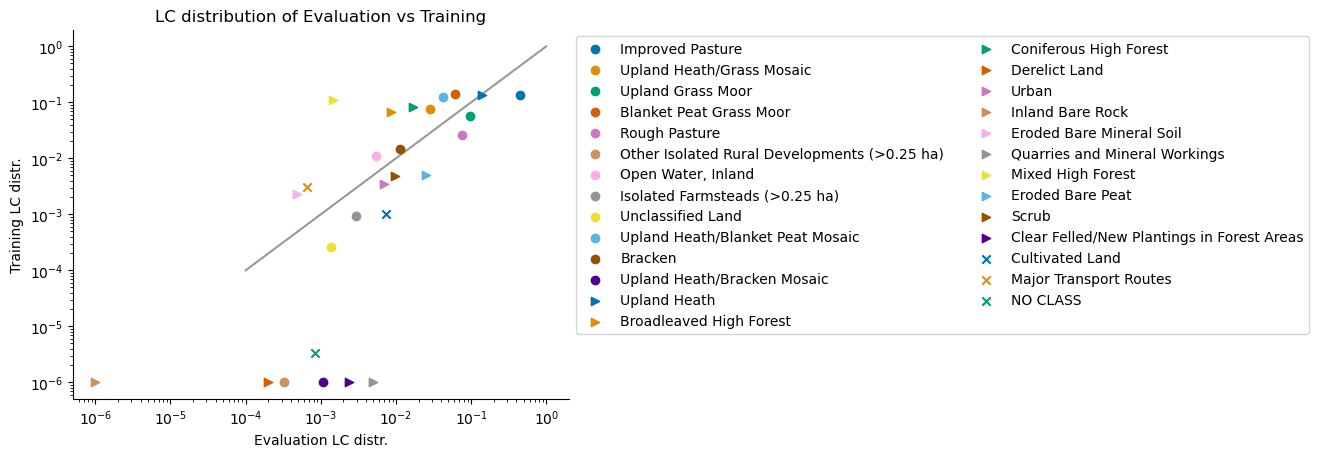

In [9]:
lcv.plot_scatter_class_distr_two_dfs(df_1=dict_df_class_distr['eval'], label_1='Evaluation',
                                     df_2=dict_df_class_distr['cde_training'], label_2='Training',
                                    #  df_1=df_lc_sample, label_1='sample',
                                    #  df_2=df_lc_sample_remainder, label_2='remainder',
                                     save_fig=False)

In [18]:
dict_df_tiles['all'].iloc[inds_tiles].plot()

NameError: name 'inds_tiles' is not defined

In [39]:
df_tiles_sample = df_all_tiles.iloc[inds_tiles]
# df_tiles_sample.to_file('content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')

## Compare AREA column vs area calculation of polygon:

In [ ]:
# np.isclose(df_lc_80s['AREA'], df_lc_80s['geometry'].area).sum()
# 
plt.plot(df_lc_80s['AREA'], df_lc_80s['geometry'].area, '.')
plt.xlabel('Reported Area')
plt.ylabel('Polygon area')
print(np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e4)[0])

In [ ]:
# i_pol = 37
# print(df_lc_80s.iloc[i_pol])
for i_pol in np.where(np.abs(df_lc_80s['AREA'] - df_lc_80s['geometry'].area) > 1e2)[0]:
    print(i_pol, df_lc_80s.iloc[i_pol]['LC_D_80'])
    print(f'Area of pol is {df_lc_80s.iloc[i_pol]["geometry"].area / 1e6} km^2, but DF says {df_lc_80s.iloc[i_pol]["AREA"] / 1e6}')


In [ ]:
df_lc_80s['AREA'].max() / 1e6

In [ ]:
print(f'Total area according to DF is {df_lc_80s["AREA"].sum() / 1e6} km^2 but according to pol {df_lc_80s["geometry"].area.sum() / 1e6} km^2')

In [ ]:
ax_distr, _ = lcv.plot_distr_classes_from_shape(df_lc=df_lc_80s)
ax_distr.set_title('Distribution of LC of entire PD')